In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [70]:
df_ratings = pd.read_csv('all_ratings.csv')
df_final_ratings = pd.read_csv('final_ratings.csv')
merged_ratings_uk = pd.read_csv('matched_vehicles_v2.csv')
merged_ratings_uk.rename(columns = {'Vehicle_Make' : "MAKE", 'NCAP_Model_Name' : 'MODEL', 'Vehicle_Year' : 'MODEL_YR'}, inplace = 'True')

In [71]:
print(merged_ratings_uk.shape)

(245571, 40)


## Merging vehicles data with severe casualty and total casualty count for that car/van

In [72]:

#getting severe casualty count for matched vehicles
df_uk_casualties = pd.read_csv('data/uk_casualties.csv', encoding = 'unicode_escape')

df_uk_casualties['Accident_Index'] = df_uk_casualties['Accident_Index'].astype(str)
df_uk_casualties['Vehicle_Reference'] = df_uk_casualties['Vehicle_Reference'].astype(str)

df_uk_casualties_severe = df_uk_casualties[(df_uk_casualties['Casualty_Severity'] == 1) | (df_uk_casualties['Casualty_Severity'] == 2)]
df_uk_casualties_severe['Counter']=1
df_uk_casualties_severe = df_uk_casualties_severe.groupby(['Accident_Index', 'Vehicle_Reference'])[['Counter']].sum().reset_index()
df_uk_casualties_severe.rename(columns = {"Counter" : "Severe_Casualty_Count"}, inplace=True)

df_uk_casualties_total = df_uk_casualties[(df_uk_casualties['Casualty_Severity'] == 1) | (df_uk_casualties['Casualty_Severity'] == 2) | (df_uk_casualties['Casualty_Severity'] == 3)]
df_uk_casualties_total['Counter']=1
df_uk_casualties_total = df_uk_casualties_total.groupby(['Accident_Index', 'Vehicle_Reference'])[['Counter']].sum().reset_index()
df_uk_casualties_total.rename(columns = {"Counter" : "Total_Casualty_Count"}, inplace=True)

#merging matched vehicles with severe casualty count and total casualty count in that particular vehicle
merged_ratings_uk['Accident_Index'] = merged_ratings_uk['Accident_Index'].astype(str)
df_uk_casualties_severe['Accident_Index'] = df_uk_casualties_severe['Accident_Index'].astype(str)
df_uk_casualties_total['Accident_Index'] = df_uk_casualties_total['Accident_Index'].astype(str)
merged_ratings_uk['Vehicle_Reference'] = merged_ratings_uk['Vehicle_Reference'].astype(str)
df_uk_casualties_severe['Vehicle_Reference'] = df_uk_casualties_severe['Vehicle_Reference'].astype(str)
df_uk_casualties_total['Vehicle_Reference'] = df_uk_casualties_total['Vehicle_Reference'].astype(str)

merged_ratings_uk = pd.merge(merged_ratings_uk, df_uk_casualties_total, on = ['Accident_Index', 'Vehicle_Reference'], how = 'left')
merged_ratings_uk = pd.merge(merged_ratings_uk, df_uk_casualties_severe, on = ['Accident_Index', 'Vehicle_Reference'], how = 'left')



/Users/jyoti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:

#merged uk vehicles(car/van) and respective ratings
#merged_ratings_uk = pd.merge(df_matched_veh_cas, df_stars_only_no_dup, on = ['MAKE', 'MODEL', 'MODEL_YR'], how = 'left')
merged_ratings_uk_map = {
    'Vehicle_Type': {'Car': 1, 'Van <=3.5 t.': 2},
    'Vehicle_Manoeuvre': {'Reversing': 1, 'Parked': 2, 'Waiting to go - held up': 3, 'Slowing or stopping': 4,
                          'Moving off': 5, 'U-turn': 6, 'Turning left': 7, 'Waiting to turn left': 8,
                          'Turning right': 9, 'Waiting to turn right': 10, 'Changing lane to left':11,
                          'Changing lane to right': 12, 'Overtaking moving vehicle - offside':13, 'Overtaking moving vehicle – offside': 13,
                          'Overtaking static vehicle - offside': 14, 'Overtaking - nearside':15,
                          'Going ahead left-hand bend': 16, 'Going ahead right-hand bend': 17, 'Going ahead other' :18,
                          -1: np.nan},
    '1st_Point_of_Impact': {'Did not impact': 0, 'Front': 1, 'Back': 2, 'Offside': 3, 'Nearside': 4,-1: np.nan},
    'Sex_of_Driver': {'Male': 1, 'Female': 2, -1: np.nan}
}
for key in merged_ratings_uk_map:
    for old_value in merged_ratings_uk_map[key]:
        merged_ratings_uk[key] = merged_ratings_uk[key].replace(old_value, merged_ratings_uk_map[key][old_value])
merged_ratings_uk = merged_ratings_uk.drop(columns=['Junction_Location', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway',
                                                  'Hit_Object_off_Carriageway','Journey_Purpose_of_Driver', 'Driver_Home_Area_Type',
                                                   'VEHICLE_ID', 'Vehicle_Reference', 'Vehicle_Location-Restricted_Lane'])
merged_ratings_uk.keys()


Index(['Unnamed: 0', 'Accident_Index', 'Vehicle_Type', 'Vehicle_Manoeuvre',
       'Skidding_and_Overturning', '1st_Point_of_Impact', 'Sex_of_Driver',
       'Age_of_Driver', 'Age_Band_of_Driver', 'Engine_Capacity_(CC)',
       'Propulsion_Code', 'Age_of_Vehicle', 'MAKE', 'Vehicle_Model',
       'MODEL_YR', 'MODEL', 'OVERALL_STARS', 'FRNT_DRIV_STARS',
       'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS',
       'SIDE_PASS_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY',
       'ROLLOVER_POSSIBILITY_2', 'ROLL_SAFETY_CONCERN', 'SIDE_POLE_STARS',
       'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT',
       'proc_MODEL', 'Total_Casualty_Count', 'Severe_Casualty_Count'],
      dtype='object')

## Point of impact 'Front' - Severe casualty wrt demographic (age and gender)

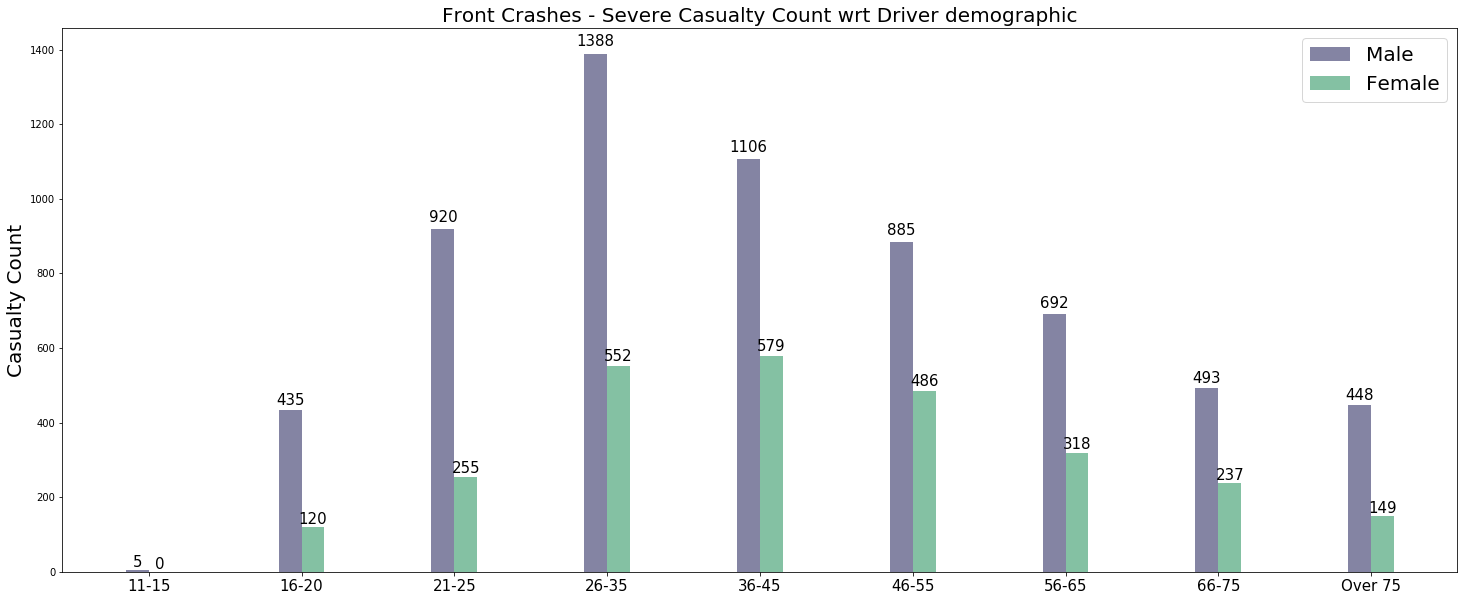

In [74]:
# 116963/245571 - front/total vehicle accidents in the matched_vehicles csv
veh_impact_front = merged_ratings_uk.copy(deep=True)
veh_impact_front = veh_impact_front.loc[veh_impact_front['1st_Point_of_Impact'] == 1]
veh_impact_front = veh_impact_front.drop(columns=['Engine_Capacity_(CC)', 'MAKE', 'Vehicle_Manoeuvre','Accident_Index','Vehicle_Type', 'Skidding_and_Overturning', 
                                                  'MODEL','MODEL_YR', '1st_Point_of_Impact','Propulsion_Code', 'Age_of_Vehicle', ])
fig, ax = plt.subplots(figsize=(25,10))
plot_front_age_gender = veh_impact_front.dropna(subset=['Age_Band_of_Driver', 'Severe_Casualty_Count'])
plot_front_age_gender = plot_front_age_gender.sort_values(by=['Age_Band_of_Driver'])
x = np.arange(len(plot_front_age_gender['Age_Band_of_Driver'].unique()))
bar_width = 0.15
b1 = ax.bar(x, [len(plot_front_age_gender.loc[(plot_front_age_gender['Sex_of_Driver'] == 1) & (plot_front_age_gender['Age_Band_of_Driver'] == x)])
                            for x in plot_front_age_gender['Age_Band_of_Driver'].unique()], width=bar_width, color=(0.2, 0.2, 0.4, 0.6))
b2 = ax.bar(x + bar_width, [len(plot_front_age_gender.loc[(plot_front_age_gender['Sex_of_Driver'] == 2) & (plot_front_age_gender['Age_Band_of_Driver'] == x)])
                            for x in plot_front_age_gender['Age_Band_of_Driver'].unique()], width=bar_width, color=(0.2, 0.6, 0.4, 0.6))

# x-axis
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(plot_front_age_gender['Age_Band_of_Driver'].unique(), fontsize=15)

#y-axis
ax.set_ylabel(('Casualty Count') , fontsize=20)
ax.set_title(('Front Crashes - Severe Casualty Count wrt Driver demographic'), fontsize=20)

#legend
ax.legend((b1[0], b2[0]), ('Male', 'Female'), prop={'size': 20})

#label for each bar
def autolabel(bar):
    
    for b in bar:
        height = b.get_height()
        ax.text(b.get_x() + b.get_width()/2., 1.01*height,'%d' % int(height), ha='center', va='bottom', fontsize=15)

autolabel(b1)
autolabel(b2)


## Point of impact 'Back' - Severe casualty wrt demographic (age and gender)

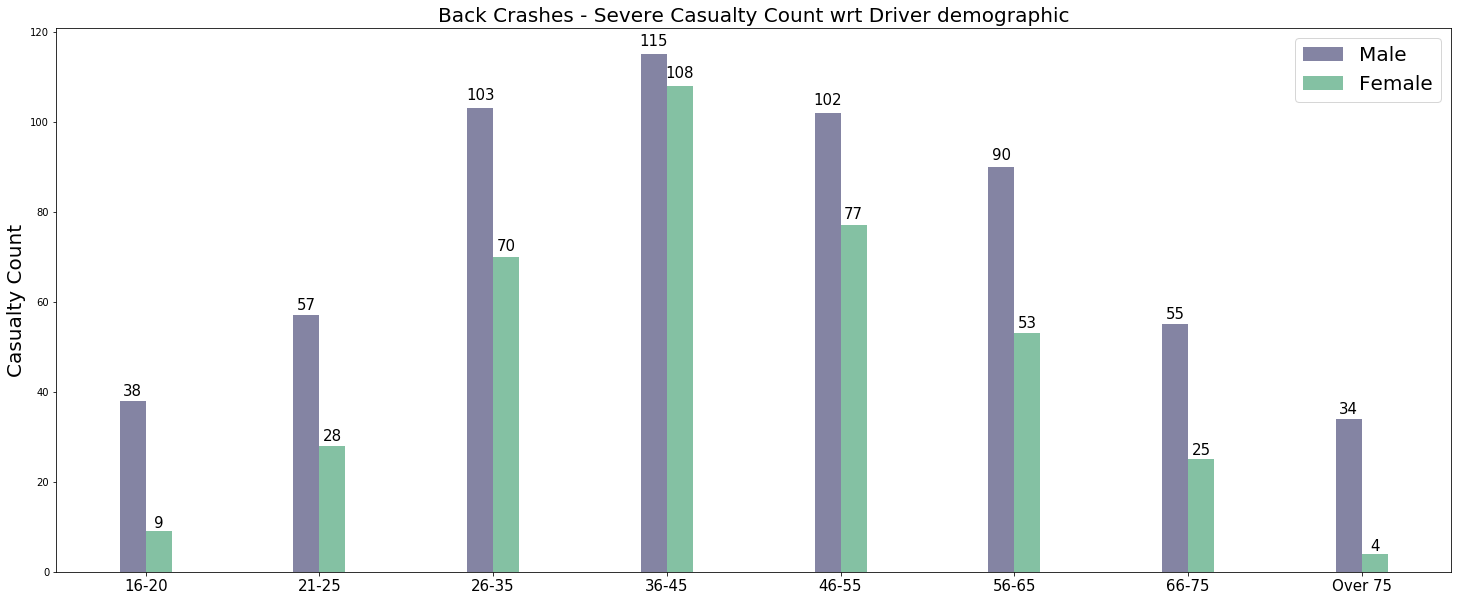

In [75]:
# 55277/245571 - back/total vehicle accidents in the matched_vehicles csv
veh_impact_back = merged_ratings_uk.copy(deep=True)
veh_impact_back = veh_impact_back.loc[veh_impact_back['1st_Point_of_Impact'] == 2]
veh_impact_back = veh_impact_back.drop(columns=['Engine_Capacity_(CC)', 'MAKE', 'Vehicle_Manoeuvre','Accident_Index','Vehicle_Type', 'Skidding_and_Overturning', 
                                                  'MODEL','MODEL_YR', '1st_Point_of_Impact','Propulsion_Code', 'Age_of_Vehicle', ])
fig, ax = plt.subplots(figsize=(25,10))
plot_back_age_gender = veh_impact_back.dropna(subset=['Age_Band_of_Driver', 'Severe_Casualty_Count'])

plot_back_age_gender = plot_back_age_gender.sort_values(by=['Age_Band_of_Driver'])
x = np.arange(len(plot_back_age_gender['Age_Band_of_Driver'].unique()))
bar_width = 0.15
b1 = ax.bar(x, [len(plot_back_age_gender.loc[(plot_back_age_gender['Sex_of_Driver'] == 1) & (plot_back_age_gender['Age_Band_of_Driver'] == x)])
                            for x in plot_back_age_gender['Age_Band_of_Driver'].unique()], width=bar_width, color=(0.2, 0.2, 0.4, 0.6))
b2 = ax.bar(x + bar_width, [len(plot_back_age_gender.loc[(plot_back_age_gender['Sex_of_Driver'] == 2) & (plot_back_age_gender['Age_Band_of_Driver'] == x)])
                            for x in plot_back_age_gender['Age_Band_of_Driver'].unique()], width=bar_width, color=(0.2, 0.6, 0.4, 0.6))

# x-axis
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(plot_back_age_gender['Age_Band_of_Driver'].unique(), fontsize=15)

#y-axis
ax.set_ylabel(('Casualty Count') , fontsize=20)
ax.set_title(('Back Crashes - Severe Casualty Count wrt Driver demographic'), fontsize=20)

#legend
ax.legend((b1[0], b2[0]), ('Male', 'Female'), prop={'size': 20})

#label for each bar
def autolabel(bar):
    
    for b in bar:
        height = b.get_height()
        ax.text(b.get_x() + b.get_width()/2., 1.01*height,'%d' % int(height), ha='center', va='bottom', fontsize=15)

autolabel(b1)
autolabel(b2)

## Point of impact 'Side' - Severe casualty wrt demographic (age and gender)

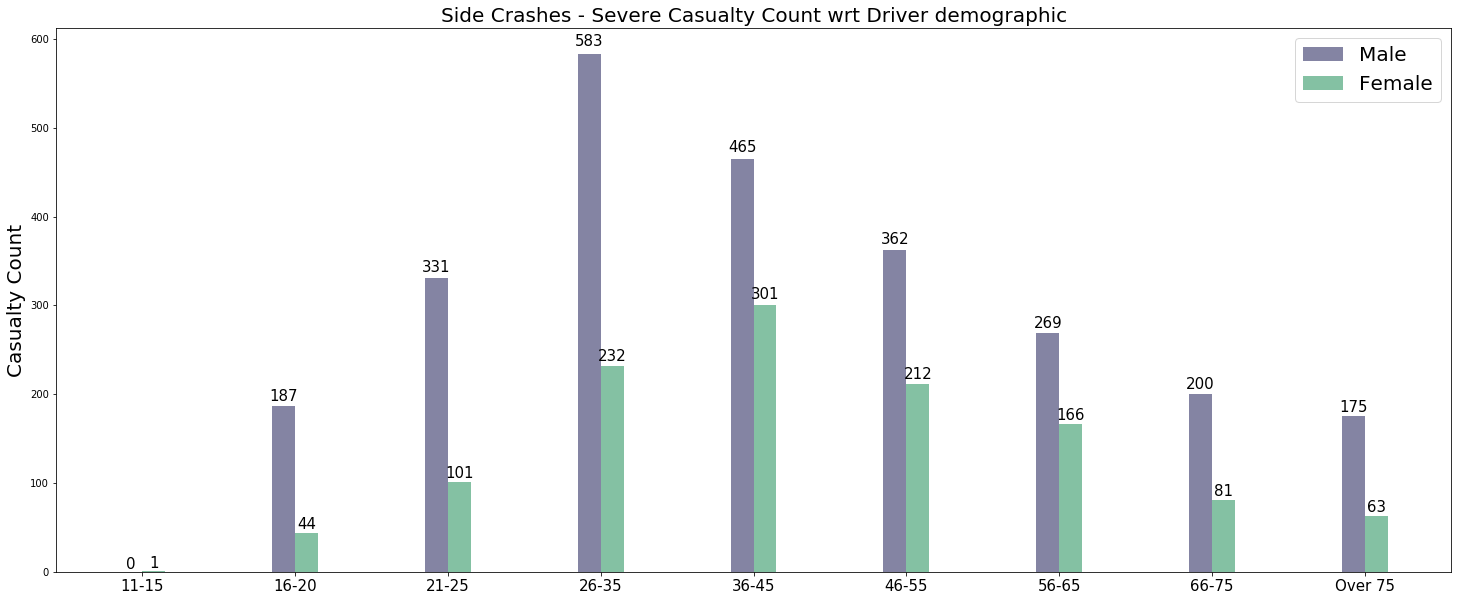

In [76]:
# 64580/245571 - side/total vehicle accidents in the matched_vehicles csv
veh_impact_side = merged_ratings_uk.copy(deep=True)
veh_impact_side = veh_impact_side.loc[(veh_impact_side['1st_Point_of_Impact'] == 3) | (veh_impact_side['1st_Point_of_Impact'] == 4)]
veh_impact_side = veh_impact_side.drop(columns=['Engine_Capacity_(CC)', 'MAKE', 'Vehicle_Manoeuvre','Accident_Index','Vehicle_Type', 'Skidding_and_Overturning', 
                                                  'MODEL','MODEL_YR', '1st_Point_of_Impact','Propulsion_Code', 'Age_of_Vehicle', ])
fig, ax = plt.subplots(figsize=(25,10))
plot_side_age_gender = veh_impact_side.dropna(subset=['Age_Band_of_Driver', 'Severe_Casualty_Count'])

plot_side_age_gender = plot_side_age_gender.sort_values(by=['Age_Band_of_Driver'])
x = np.arange(len(plot_side_age_gender['Age_Band_of_Driver'].unique()))
bar_width = 0.15
b1 = ax.bar(x, [len(plot_side_age_gender.loc[(plot_side_age_gender['Sex_of_Driver'] == 1) & (plot_side_age_gender['Age_Band_of_Driver'] == x)])
                            for x in plot_side_age_gender['Age_Band_of_Driver'].unique()], width=bar_width, color=(0.2, 0.2, 0.4, 0.6))
b2 = ax.bar(x + bar_width, [len(plot_side_age_gender.loc[(plot_side_age_gender['Sex_of_Driver'] == 2) & (plot_side_age_gender['Age_Band_of_Driver'] == x)])
                            for x in plot_side_age_gender['Age_Band_of_Driver'].unique()], width=bar_width, color=(0.2, 0.6, 0.4, 0.6))

# x-axis
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(plot_side_age_gender['Age_Band_of_Driver'].unique(), fontsize=15)

#y-axis
ax.set_ylabel(('Casualty Count') , fontsize=20)
ax.set_title(('Side Crashes - Severe Casualty Count wrt Driver demographic'), fontsize=20)

#legend
ax.legend((b1[0], b2[0]), ('Male', 'Female'), prop={'size': 20})

#label for each bar
def autolabel(bar):
    
    for b in bar:
        height = b.get_height()
        ax.text(b.get_x() + b.get_width()/2., 1.01*height,'%d' % int(height), ha='center', va='bottom', fontsize=15)

autolabel(b1)
autolabel(b2)

## Vehicles with rollover possibility >0 , in overturning accidents where total #accidents >50

In [77]:
veh_roll_poss = merged_ratings_uk.copy(deep=True)
veh_roll_poss['ROLLOVER_POSSIBILITY'].astype(float)
veh_roll_poss['ROLLOVER_POSSIBILITY'].replace(0, np.nan, inplace=True)
veh_roll_poss.dropna(subset=['ROLLOVER_POSSIBILITY'], inplace=True)
veh_roll_poss['COUNTER'] =1
group_veh_roll_poss = veh_roll_poss.groupby(['MAKE', 'MODEL'])['COUNTER'].sum().reset_index()
veh_overturned = veh_roll_poss.loc[(veh_roll_poss['Skidding_and_Overturning'] == 2) | (veh_roll_poss['Skidding_and_Overturning'] == 4) | (veh_roll_poss['Skidding_and_Overturning'] == 5)]
veh_overturned['COUNTER'] =1
group_veh_overturned = veh_overturned.groupby(['MAKE', 'MODEL'])['COUNTER'].sum().reset_index()
group_veh_overturned = pd.merge(group_veh_overturned, group_veh_roll_poss,how="left",on=['MAKE', 'MODEL'])
group_veh_overturned.rename(columns={"COUNTER_x": "ROLLOVER_ACC", "COUNTER_y": "TOTAL_ACC"}, inplace=True)
group_veh_overturned['PERCENT_ROLL_OF_TOTAL'] = (group_veh_overturned['ROLLOVER_ACC']/group_veh_overturned['TOTAL_ACC']) * 100
group_veh_overturned = pd.merge(group_veh_overturned, veh_roll_poss[['ROLLOVER_POSSIBILITY', 'MAKE', 'MODEL']], how="left",on=['MAKE', 'MODEL'])
group_veh_overturned = group_veh_overturned.loc[group_veh_overturned['TOTAL_ACC'] >50]

/Users/jyoti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
plot = group_veh_overturned.copy(deep=True)
plot = plot.sort_values(by = ['PERCENT_ROLL_OF_TOTAL'])
fig = px.scatter(plot, x="PERCENT_ROLL_OF_TOTAL", y="ROLLOVER_POSSIBILITY", color="MAKE",size="PERCENT_ROLL_OF_TOTAL", width=800, height=600)
fig.update_xaxes(title='% Rollover accidents', showgrid=False, zeroline=False)
fig.update_yaxes(title='Rollover Possibility', showgrid=False, zeroline=False)
fig.update_layout(title={'text': "ALL MAKES",'y':0.95,'x':0.45})
fig.show()

In [ ]:
audi = group_veh_overturned.loc[group_veh_overturned['MAKE'] == 'AUDI']
audi = audi.sort_values(by = ['PERCENT_ROLL_OF_TOTAL'])
fig = px.scatter(audi, x="PERCENT_ROLL_OF_TOTAL", y="ROLLOVER_POSSIBILITY", color="MODEL",size="PERCENT_ROLL_OF_TOTAL", width=1000, height=500)
fig.update_xaxes(title='% Rollover accidents', showgrid=False, zeroline=False)
fig.update_yaxes(title='Rollover Possibility', showgrid=False, zeroline=False)
fig.update_layout(title={'text': "AUDI",'y':0.92,'x':0.45})
fig.show()

In [ ]:
ford = group_veh_overturned.loc[group_veh_overturned['MAKE'] == 'FORD']
ford = ford.sort_values(by = ['PERCENT_ROLL_OF_TOTAL'])
fig = px.scatter(ford, x="PERCENT_ROLL_OF_TOTAL", y="ROLLOVER_POSSIBILITY", color="MODEL",size="PERCENT_ROLL_OF_TOTAL", width=1000, height=500)
fig.update_xaxes(title='% Rollover accidents', showgrid=False, zeroline=False)
fig.update_yaxes(title='Rollover Possibility', showgrid=False, zeroline=False)
fig.update_layout(title={'text': "FORD",'y':0.92,'x':0.45})
fig.show()

In [ ]:
vo = group_veh_overturned.loc[group_veh_overturned['MAKE'] == 'VOLKSWAGEN']
vo = vo.sort_values(by = ['PERCENT_ROLL_OF_TOTAL'])
fig = px.scatter(vo, x="PERCENT_ROLL_OF_TOTAL", y="ROLLOVER_POSSIBILITY", color="MODEL",size="PERCENT_ROLL_OF_TOTAL", width=1000, height=500)
fig.update_xaxes(title='% Rollover accidents', showgrid=False, zeroline=False)
fig.update_yaxes(title='Rollover Possibility', showgrid=False, zeroline=False)
fig.update_layout(title={'text': "VOLKSWAGEN",'y':0.92,'x':0.45})
fig.show()

In [ ]:
jeep = group_veh_overturned.loc[group_veh_overturned['MAKE'] == 'JEEP']
jeep = jeep.sort_values(by = ['PERCENT_ROLL_OF_TOTAL'])
fig = px.scatter(jeep, x="PERCENT_ROLL_OF_TOTAL", y="ROLLOVER_POSSIBILITY", color="MODEL",size="PERCENT_ROLL_OF_TOTAL", width=1000, height=500)
fig.update_xaxes(title='% Rollover accidents', showgrid=False, zeroline=False)
fig.update_yaxes(title='Rollover Possibility', showgrid=False, zeroline=False)
fig.update_layout(title={'text': "JEEP",'y':0.92,'x':0.45})
fig.show()

In [ ]:
kia = group_veh_overturned.loc[group_veh_overturned['MAKE'] == 'KIA']
kia = kia.sort_values(by = ['PERCENT_ROLL_OF_TOTAL'])
fig = px.scatter(kia, x="PERCENT_ROLL_OF_TOTAL", y="ROLLOVER_POSSIBILITY", color="MODEL",size="PERCENT_ROLL_OF_TOTAL", width=1000, height=500)
fig.update_xaxes(title='% Rollover accidents', showgrid=False, zeroline=False)
fig.update_yaxes(title='Rollover Possibility', showgrid=False, zeroline=False)
fig.update_layout(title={'text': "KIA",'y':0.92,'x':0.45})
fig.show()

In [ ]:
honda = group_veh_overturned.loc[group_veh_overturned['MAKE'] == 'HONDA']
honda = honda.sort_values(by = ['PERCENT_ROLL_OF_TOTAL'])
fig = px.scatter(honda, x="PERCENT_ROLL_OF_TOTAL", y="ROLLOVER_POSSIBILITY", color="MODEL",size="PERCENT_ROLL_OF_TOTAL", width=1000, height=500)
fig.update_xaxes(title='% Rollover accidents', showgrid=False, zeroline=False)
fig.update_yaxes(title='Rollover Possibility', showgrid=False, zeroline=False)
fig.update_layout(title={'text': "HONDA",'y':0.92,'x':0.45})
fig.show()

In [ ]:
maz = group_veh_overturned.loc[group_veh_overturned['MAKE'] == 'MAZDA']
maz = maz.sort_values(by = ['PERCENT_ROLL_OF_TOTAL'])
fig = px.scatter(maz, x="PERCENT_ROLL_OF_TOTAL", y="ROLLOVER_POSSIBILITY", color="MODEL",size="PERCENT_ROLL_OF_TOTAL", width=1000, height=500)
fig.update_xaxes(title='% Rollover accidents', showgrid=False, zeroline=False)
fig.update_yaxes(title='Rollover Possibility', showgrid=False, zeroline=False)
fig.update_layout(title={'text': "MAZDA",'y':0.92,'x':0.45})
fig.show()

In [ ]:
sub = group_veh_overturned.loc[group_veh_overturned['MAKE'] == 'SUBARU']
sub = sub.sort_values(by = ['PERCENT_ROLL_OF_TOTAL'])
fig = px.scatter(sub, x="PERCENT_ROLL_OF_TOTAL", y="ROLLOVER_POSSIBILITY", color="MODEL",size="PERCENT_ROLL_OF_TOTAL", width=1000, height=500)
fig.update_xaxes(title='% Rollover accidents', showgrid=False, zeroline=False)
fig.update_yaxes(title='Rollover Possibility', showgrid=False, zeroline=False)
fig.update_layout(title={'text': "SUBARU",'y':0.92,'x':0.45})
fig.show()

In [ ]:
'''
#dropping rows where all the 10 stars(10 star ratings) are 'not rated' ie na
df_stars = df_ratings.replace('Not Rated', np.nan)
df_stars = df_stars.dropna(subset=['OVERALL_STARS', 'OVERALL_FRNT_STARS','FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS','ROLLOVER_STARS','ROLLOVER_STARS_2', 'SIDE_POLE_STARS'], how='all')

#dropping all columns except stars or other numercial counts, done to help remove duplicates
df_stars_only = df_stars.drop( columns = ['VEHICLE_PICTURE','FRNT_FOOT_NOTES_DRIV','FRNT_FOOT_NOTES_PASS', 'FRNT_SAFETY_CONCERN_DRIV',
                                     'FRNT_SAFETY_CONCERN_PASS', 'FRNT_CRASH_PICTURE', 'FRNT_CRASH_VIDEO',
                                     'SIDE_FOOT_NOTES_DRIV', 'SIDE_FOOT_NOTES_PASS','SIDE_SAFETY_CONCERN_DRIV', 'SIDE_SAFETY_CONCERN_PASS',
                                     'SIDE_CRASH_PICTURE', 'SIDE_CRASH_VIDEO','ROLL_FOOT_NOTES', 'ROLL_SAFETY_CONCERN', 
                                     'POLE_FOOT_NOTES', 'POLE_SAFETY_CONCERN', 'SIDE_POLE_PICTURE','SIDE_POLE_VIDEO', 'NHTSA_ESC', 
                                     'NHTSA_FRNT_COLLISION_WARNING','NHTSA_LANE_DEPARTURE_WARNING', 'NHTSA_BACKUP_CAMERA'])
print(df_stars_only.shape)
print(df_stars_only.keys())

#stars_only - table with only star ratings of all cars
#stars_only_no_dup - table with duplicates removed for combination of make, model, year
'''

# Removing duplicates from Star Ratings

In [ ]:
'''
#keeping only first entries of all duplicates and checking if nan values exist
df_stars_only_no_dup = df_stars_only.drop_duplicates(subset=['MAKE', 'MODEL', 'MODEL_YR'], keep='first')
print(df_stars_only_no_dup.shape)

#merging with the duplicates wherever NaN values found in original and not-nan found in duplicate
for index, row in df_stars_only_no_dup.iterrows():
    make = row['MAKE']
    model = row['MODEL']
    year = row['MODEL_YR']
    
    df = df_stars_only.loc[(df_stars_only['MAKE'] == make) & (df_stars_only['MODEL'] == model) & (df_stars_only['MODEL_YR'] == year)]
    row['OVERALL_STARS'] = df['OVERALL_STARS'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'OVERALL_STARS'] = row['OVERALL_STARS'] 
    row['OVERALL_FRNT_STARS'] = df['OVERALL_FRNT_STARS'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'OVERALL_FRNT_STARS'] = row['OVERALL_FRNT_STARS'] 
    row['FRNT_DRIV_STARS'] = df['FRNT_DRIV_STARS'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'FRNT_DRIV_STARS'] = row['FRNT_DRIV_STARS'] 
    row['FRNT_PASS_STARS'] = df['FRNT_PASS_STARS'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'FRNT_PASS_STARS'] = row['FRNT_PASS_STARS'] 
    row['OVERALL_SIDE_STARS'] = df['OVERALL_SIDE_STARS'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'OVERALL_SIDE_STARS'] = row['OVERALL_SIDE_STARS'] 
    row['SIDE_DRIV_STARS'] = df['SIDE_DRIV_STARS'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'SIDE_DRIV_STARS'] = row['SIDE_DRIV_STARS'] 
    row['SIDE_PASS_STARS'] = df['SIDE_PASS_STARS'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'SIDE_PASS_STARS'] = row['SIDE_PASS_STARS'] 
    row['ROLLOVER_STARS'] = df['ROLLOVER_STARS'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'ROLLOVER_STARS'] = row['ROLLOVER_STARS'] 
    row['ROLLOVER_STARS_2'] = df['ROLLOVER_STARS_2'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'ROLLOVER_STARS_2'] = row['ROLLOVER_STARS_2'] 
    row['ROLLOVER_POSSIBILITY'] = df['ROLLOVER_POSSIBILITY'].dropna().unique().astype(float).mean()
    df_stars_only_no_dup.at[index,'ROLLOVER_POSSIBILITY'] = row['ROLLOVER_POSSIBILITY'] 
    row['ROLLOVER_POSSIBILITY_2'] = df['ROLLOVER_POSSIBILITY_2'].dropna().unique().astype(float).mean()
    df_stars_only_no_dup.at[index,'ROLLOVER_POSSIBILITY_2'] = row['ROLLOVER_POSSIBILITY_2'] 
    row['SIDE_POLE_STARS'] = df['SIDE_POLE_STARS'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'SIDE_POLE_STARS'] = row['SIDE_POLE_STARS'] 
    row['COMPLAINTS_COUNT'] = df['COMPLAINTS_COUNT'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'COMPLAINTS_COUNT'] = row['COMPLAINTS_COUNT'] 
    row['RECALLS_COUNT'] = df['RECALLS_COUNT'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'RECALLS_COUNT'] = row['RECALLS_COUNT'] 
    row['INVESTIGATIONS_COUNT'] = df['INVESTIGATIONS_COUNT'].dropna().unique().astype(int).mean()
    df_stars_only_no_dup.at[index,'INVESTIGATIONS_COUNT'] = row['INVESTIGATIONS_COUNT'] 
'''

In [ ]:
'''
df_stars_only_no_dup['MODEL_YR'] = df_stars_only_no_dup['MODEL_YR'].astype(int)
df_stars_only_no_dup['MODEL'] = df_stars_only_no_dup['MODEL'].astype(str)
df_stars_only_no_dup['MAKE'] = df_stars_only_no_dup['MAKE'].astype(str)
df_matched_veh_cas['MODEL_YR'] = df_matched_veh_cas['MODEL_YR'].astype(int)
df_matched_veh_cas['MODEL'] = df_matched_veh_cas['MODEL'].astype(str)
df_matched_veh_cas['MAKE'] = df_matched_veh_cas['MAKE'].astype(str)
'''